In [1]:
%%html
<link rel="stylesheet" href="static/hyrule.css" type="text/css">

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Linear Regressions as an Exploratory Tool

## Objectives

* How to analyze the distributions in your data with scatterplots and histograms
* How to use data relationships to get results
* Interepretation of statsmodels coefficient tables


### Code Dictionary

code | description
-----|------------
`sm.qqplot()` | generates a qq plot using matplotlib. Arguments commonly include vector you want to use, and the distribution type.
`smf.ols(formula, data)` | Using the statsmodels api, generates a ordinary least squares linear regression object. the formula is borrowed from R syntax, and can reference DataFrame columns
`.fit()` | computes the results of the ols model object.  Effectively, it solves for $y = \alpha x + \beta + e$
`.summary()` | returns the summary from the computed results from `.fit()`
`sns.lmplot(x, y, data)` | performs a linear regression and plots the model against x and y. Very useful for representing single variable performance.
`sm.stats.anova_lm()` | Generates an ANOVA (analysis of variance) table.
`.get_influence().summary_table()` | Generates a table of information for the residuals of each observation from a given linear model


### Class Notes

### Understanding distributions

Load in the following data set about mammals and their sleeping patterns. The columns of the dataset are defined as followed:

```
name: common name
genus
vore: carnivore, omnivore or herbivore?
order
conservation: the conservation status of the animal
sleep_total: total amount of sleep, in hours
sleep_rem: rem sleep, in hours
sleep_cycle: length of sleep cycle, in hours
awake: amount of time spent awake, in hours
brainwt: brain weight in kilograms
bodywt: body weight in kilograms
```

                         name       genus   vore         order  conservation  \
0                     Cheetah    Acinonyx  carni     Carnivora            lc   
1                  Owl monkey       Aotus   omni      Primates           NaN   
2             Mountain beaver  Aplodontia  herbi      Rodentia            nt   
3  Greater short-tailed shrew     Blarina   omni  Soricomorpha            lc   
4                         Cow         Bos  herbi  Artiodactyla  domesticated   

   sleep_total  sleep_rem  sleep_cycle  awake  brainwt   bodywt  
0         12.1        NaN          NaN   11.9      NaN   50.000  
1         17.0        1.8          NaN    7.0  0.01550    0.480  
2         14.4        2.4          NaN    9.6      NaN    1.350  
3         14.9        2.3     0.133333    9.1  0.00029    0.019  
4          4.0        0.7     0.666667   20.0  0.42300  600.000  


/Users/alexlove/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,sleep_total,sleep_rem,sleep_cycle,awake,brainwt,bodywt
count,83.000000,61.000000,32.000000,83.000000,56.000000,83.000000
mean,10.433735,1.875410,0.439583,13.567470,0.281581,166.136349
std,4.450357,1.298288,0.358680,4.452085,0.976414,786.839732
min,1.900000,0.100000,0.116667,4.100000,0.000140,0.005000
25%,7.850000,NaN,NaN,10.250000,NaN,0.174000
50%,10.100000,NaN,NaN,13.900000,NaN,1.670000
75%,13.750000,NaN,NaN,16.150000,NaN,41.750000
max,19.900000,6.600000,1.500000,22.100000,5.712000,6654.000000


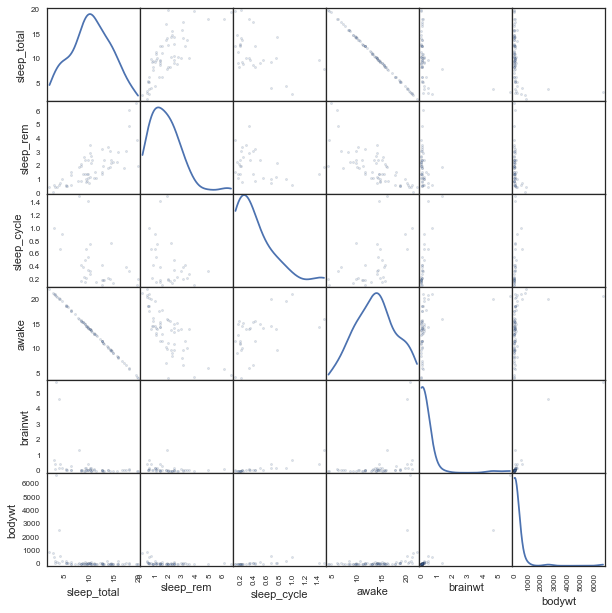

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('white')
spat = pd.read_csv('../data/msleep.csv')

pd.scatter_matrix(spat, figsize=[10, 10], alpha=0.2, diagonal='kde')
print spat.head()
spat.describe()

Already from quickly scanning the KDE (kernel density estimation) plots, we recognize a few interesting relationships. KDE, like histograms, allow us to quickly visualization the distribution of our data.

### Normal distributions

Figure(640x440)


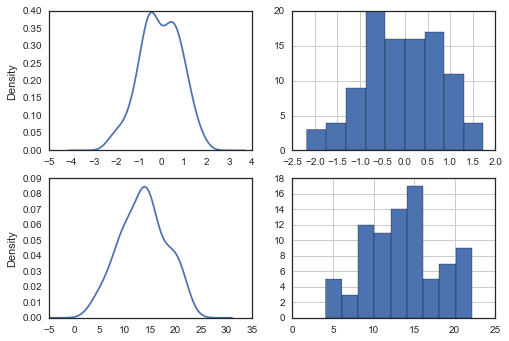

In [13]:
norm = pd.DataFrame({'d': np.random.normal(size=100)})
#norm.head()
#max - min for every column
n_bins = np.abs(spat['awake'].max() - spat['awake'].min())
#print n_bins
fig, axes = plt.subplots(nrows=2, ncols=2,)

## New notation: what does the 'ax' argument do?
norm['d'].plot(ax=axes[0, 0], kind='kde')
norm['d'].hist(ax=axes[0, 1], bins=n_bins/2)
spat['awake'].plot(ax=axes[1, 0], kind='kde')
spat['awake'].hist(ax=axes[1, 1], bins=n_bins/2)

print fig

Normal distributions are defined by their mean and standard deviation. We primarily use them in data science as it often describes as a natural state, but also because it's easy to understand and calculate. 

Above, it appears that the awake hours (or sleeping hours, as that is 24 - awake hours) seems to fit pretty close to a normal distribution---but how close?

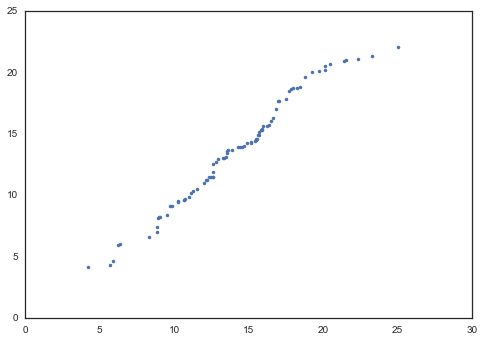

In [14]:
qq = sorted(np.random.normal(spat['awake'].mean(), spat['awake'].std(), len(spat)))
awake = sorted(spat['awake'])

plt.plot(qq, awake, '.')
plt.show()

Above, we're looking at something similar to a "qq plot." QQ plots determine how much your data is similar to a probability distribution. However, doing it the above way is obtrusive and obfuscates what we're handling. 

Statsmodels, a statistical library in python, can curate these very quickly for us.

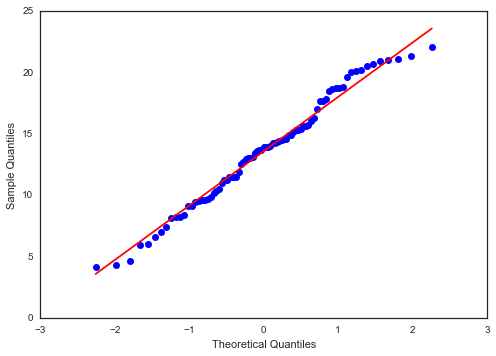

In [15]:
import statsmodels.api as sm
import scipy.stats as stats

# Check sm.qqplot() configurations with shift+tab to see how you can change the distribution you are testing against!
fig = sm.qqplot(spat['awake'], dist=stats.distributions.norm, line='s')
plt.show()

Our interpretation of the above plot would suggest a couple things:

* this data set's "awake" variable does pretty well fitting to a normal distribution
* the missing normalcy occurs around 20 hours of sleep--which is similar to the "hump" we saw in the histogram/KDE.

### Your turn: Testing Distributions

Walking through the same steps, see if there is a similar pattern for "sleep_rem". How would you explain the shape of the data to someone else?

### Heavy tail distributions and power laws

Notice in the data set above, body weight and brain weight are not normally distributed.

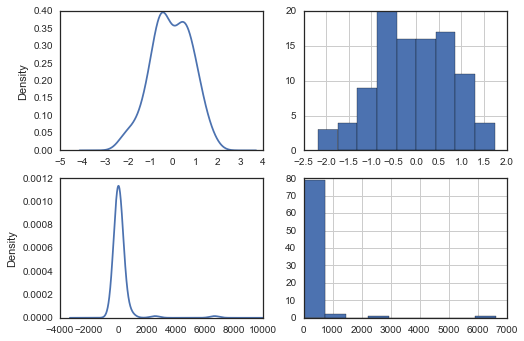

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2,)

norm['d'].plot(ax=axes[0, 0], kind='kde')
norm['d'].hist(ax=axes[0, 1], bins=n_bins/2)
spat['bodywt'].plot(ax=axes[1, 0], kind='kde')
spat['bodywt'].hist(ax=axes[1, 1], bins=n_bins/2)

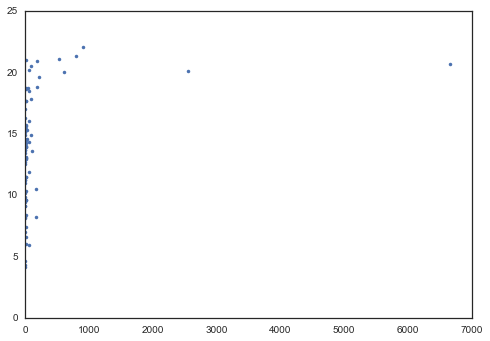

In [17]:
plt.figure()
plt.plot(spat.bodywt, spat.awake, '.')
# Clearly there isn't a linear relationship here.

One way to handle heavy tail data is with a linear transformation. 

Transposing the body weight using log manipulates the data into a shape we better understand.

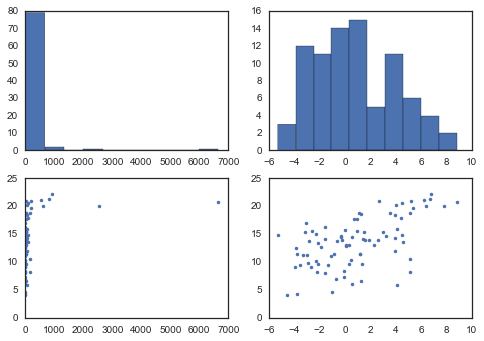

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2,)

ax[0, 0].hist(spat.bodywt)
ax[0, 1].hist(np.log(spat.bodywt))
ax[1, 0].plot(spat.bodywt, spat.awake, '.')
ax[1, 1].plot(np.log(spat.bodywt), spat.awake, '.')

plt.show()

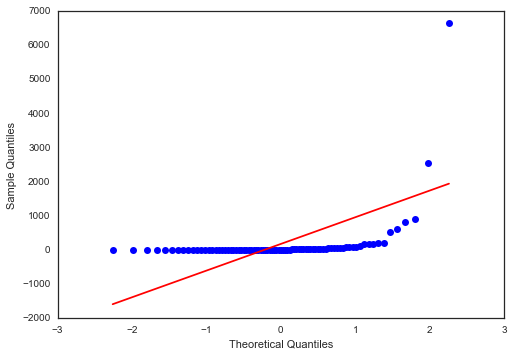

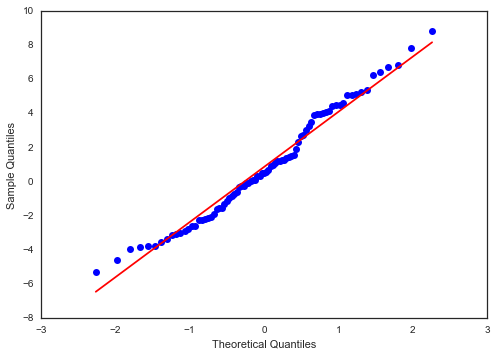

In [24]:
fig = sm.qqplot(spat['bodywt'], dist=stats.distributions.norm, line='s')
plt.show()

fig = sm.qqplot(np.log(spat['bodywt']), dist=stats.distributions.norm, line='s')
plt.show()

Keep in mind that transforming data into some other "space" doesn't mean it's [right](http://vserver1.cscs.lsa.umich.edu/~crshalizi/weblog/491.html)!



### Understanding how good the relationship is - Linear Regressions

We can also test the relationship between variables given it's statistical significance. A p-value is the probability that a correllation is due to randomness, or by chance. A low p-value means that the result is not due to randomness, while a high p-value means it is due to randomness. 

In statsmodels, we can use a coefficient table from the linear model to get our p-values. To start, observe the relationship between body mass and brain mass in the data set.

NORMAL FIT SUMMARY
                            OLS Regression Results                            
Dep. Variable:                brainwt   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     367.7
Date:                Sun, 09 Oct 2016   Prob (F-statistic):           9.16e-26
Time:                        20:09:39   Log-Likelihood:                -20.070
No. Observations:                  56   AIC:                             44.14
Df Residuals:                      54   BIC:                             48.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0859      0.048 

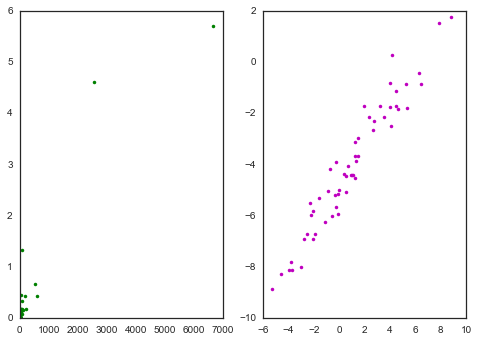

In [27]:
import statsmodels.formula.api as smf
# OLS, or ordinary least squares, takes a y (dependent variable) and X (independent variables) (formula = y ~ X)
# Below, we copy the data frame and remove the na variables, and create a single variable linear model
# to return a test statistic and p-value, to see how strong of a relationship bodyweight and brainweight have.

spat_cleaned_up = pd.DataFrame(spat)
spat_cleaned_up['bodywt'].dropna(inplace=True)
spat_cleaned_up['brainwt'].dropna(inplace=True)
spat_cleaned_up['log_bodywt'] = np.log(spat_cleaned_up['bodywt'])
spat_cleaned_up['log_brainwt'] = np.log(spat_cleaned_up['brainwt'])

fig, axes = plt.subplots(nrows=1,ncols=2)

axes[0].plot(spat_cleaned_up.bodywt, spat_cleaned_up.brainwt, 'g.')

model = smf.ols(formula='brainwt ~ bodywt', data=spat_cleaned_up)
results = model.fit()
print 'NORMAL FIT SUMMARY'
print(results.summary())
print

axes[1].plot(spat_cleaned_up.log_bodywt, spat_cleaned_up.log_brainwt, 'm.')

log_model = smf.ols(formula='log_brainwt ~ log_bodywt', data=spat_cleaned_up)
log_results = log_model.fit()
print 'LOG-LOG FIT SUMMARY'
print(log_results.summary())

print fig

Another functionality of seaborn is that it can print out linear model figures as well. Here we can see the original plots, the model that fits, and a confidence interval.

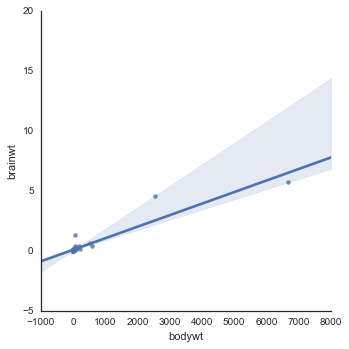

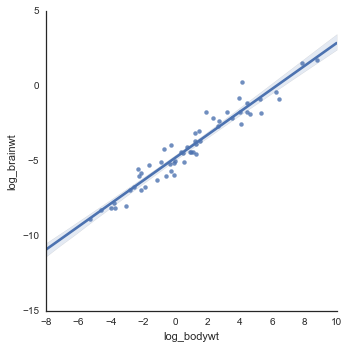

In [28]:
# Original model
print sns.lmplot(x='bodywt', y='brainwt', data=spat_cleaned_up)

# New log-log model
print sns.lmplot(x='log_bodywt', y='log_brainwt', data=spat_cleaned_up)

Words/parts of the table we should know and understand (for now):

value | description
------|------------
**<code>P>&#124;t&#124;</code>** | p values. In both cases we see significance in the relationship, but not with where the predicted y value starts
**`t`** | t-value of the coefficients (which we'll talk about more next week). It's used to determine the p-values
**`F-statistic`** and **`P(F-statistic)`** | A comparison of this how this data fits vs the same data set with less information. like the p-values above, the closer the f-statisitics p-value is to 0, the better this "fit"
**`R-squared`** | NOT a value of R (correlation) ^2, but instead a representation of "goodness of fit." For now, understand this as a value that primarily ranges between 0 and 1, 1 being the "best" fit.


Even though in both instances the p-value of the body weight is significant (p ~ 0), it's important to note that:

* The "goodness of fit" in the log-log transform is higher than the non-transformed version
* A scatter plot of each confirms that the relationship is a lot easier on the eyes as well in the log-log transform

Therefore it's incredibly useful to work with both **visualizations** and **using models** to understand data relationships.

Note that you can also get much of this information in an analysis of variance table (see below code), or further evaluate at a per-point basis.

In [1]:
print sm.stats.anova_lm(log_results, typ=2)
print
print log_results.get_influence().summary_table()

NameError: name 'sm' is not defined

### On Your Own

**Are animal sleep patterns dependent on their weight?**

We want to test the relationships between the hours of sleep_rem or sleep_cycle an animal gets, and either body weight or brain weight. Repeat the steps above in one or two cells to show:

1. Is there a linear relationship between one of these variables and the number of hours?
2. If so, what's the measure of goodness of fit?
3. Does one seem to fit better than another?

By practicing:

* creating histograms, scatterplots, and qqplots
* fitting a single variable linear model
* reading and interpreting the returning summary table


**ADVANCED**

There are missing values all over the data set. Which variables seem easy to interpolate? Include your code.

There are categorical variables that we did not use today in the data set. Consider exploring the usage of [pd.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.reshape.get_dummies.html) and creating a new model composed of the variables generated (try each at one time).

### Review, next steps, practice

* We've explored several data sets through the course so far, either captured in the `data` folder, or pulled from urls. In a similar vein, explore the relationships with variables, after determining a dependent variable, y.
* Power laws are common in our data (with a warning!). One very common distribution in business data is the Pareto distribution.
    * Learn about what they are [here](http://en.wikipedia.org/wiki/Pareto_distribution).
    * See an application of it [here](http://www.hpl.hp.com/research/idl/papers/ranking/ranking.html)
    * Read this Quora more specifically about [power laws](http://www.quora.com/In-what-conditions-would-you-expect-a-power-law-distribution-curve-to-emerge)
* If you haven't yet, please review [Python OOP](http://learnpythonthehardway.org/book/ex40.html) by next class.
* Also if you haven't yet, please bookmark all the following pages for a class "documentation" set:
    * [pandas](http://pandas.pydata.org/pandas-docs/stable/)
    * [numpy and scipy](http://docs.scipy.org/doc/)
    * [matplotlib](matplotlib.org)
    * [seaborn](http://stanford.edu/~mwaskom/software/seaborn/index.html)
    * [statsmodels](http://statsmodels.sourceforge.net/)
    * [sklearn](http://scikit-learn.org/stable/documentation.html)